In [1]:
# imports

# make notebook span width of browser window, for convenience
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
np.warnings.filterwarnings('ignore')


# import matplotlib
import matplotlib.pyplot as plt
# for jupyter notebooks to show plots inline
%matplotlib inline 

from astropy.table import Table
from astropy.io import fits


import pandas as pd 
pd.set_option('display.max_columns', 500) # convenient for 



In [2]:
# define paths

version = 'DR1'
# root = '/home/gogreen/Data/Releases/Public/'
root = '/Users/kawebb/Gogreen/data/Releases/'
dirr  =  root + version + '/'
specdir = dirr + 'SPECTROSCOPY/'
catdir = dirr + 'CATS/'
photdir = dirr + 'PHOTOMETRY/'
imdir = photdir + 'IMAGES/'
oneddir = specdir + 'OneD/'
twoddir = specdir + 'TwoD/'

In [3]:
# define cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
# useful functions for reading in catalogues and adapting them

def make_char_col(table, charcol, header='Cluster'):
    """
    Add a column to an existing table where all values are 'charcol'
    """
    charar = pd.Series(np.full(len(table),np.nan), dtype="str")
    charar[:] = charcol
    table[header] = charar
    return table

def read_header_line(fname, skipchar=0, delimiter=None, headerline=0):
    """
    fname = file name
    skipchar = int, number of FIRST charactors to skip, usually because of comment character '#'
    delimiter = string, delimiter between column names. If None, considered whitespace
    """
    with open( fname, 'r' ) as infile:
        for i in range(headerline+1):
            header_line = infile.readline()
    header_line = header_line[skipchar:]
        
    if delimiter is None:
        headers = header_line.split()
    else:
        headers = header_line.split(delimiter)
    return headers

import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from scipy.spatial import KDTree
def find_match_coord(i1, table1, table2, maxdist=1.5):  
    """
    Given two dataframe, use astropy Skycoord to find objects within maxdist of each other
    i1 - index of object in table 1 to find matches for
    table1 - reference table, with columns RA(J2000) and DEC(J2000)
    table2 - table of objects to find matches from, with columns RA(J2000) and DEC(J2000)
    returns indices (from table2) of matched objects, and flag (0=fail, 1=success)
    """
    coo = SkyCoord(ra=table1.loc[i1,'RA(J2000)']*u.degree, dec=table1.loc[i1,'DEC(J2000)']*u.degree) 
    
    catalog = SkyCoord(ra=table2['RA(J2000)'].values*u.degree, dec=table2['DEC(J2000)'].values*u.degree)  
    coo_matches, dist, _ = coo.match_to_catalog_sky(catalog) # finds NEAREST neighbour
    coo_matches = table2.index[coo_matches.tolist()]

    if (dist.arcsec>maxdist):
        return np.nan, 0
    else:
        return coo_matches, 1


# Helpful information


**Brief introduction to ipython notebooks/jupyter**

See also: http://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/
Short video: https://www.youtube.com/watch?v=jZ952vChhuI

To open from terminal, this will run in your browser (does not require internet):
    
    > jupyter notebook

A 'file directory' will open, and you can navigate to where you have a notebook, or make a new notebook. 

To close, close the associated terminal window. Closing the browser will not end the session.

Executing basics:
    - There are two modes, command mode and edit mode. 
        - If you have selected a cell and see a cursor, you are in edit mode (the cell will be outlined in green). 
        - If the cell is outlined in blue, you are in command mode. 
        - To toggle between modes, hit escape, or click on the margin of the cell.

    -  **************** Run a cell, in either mode: shift + enter ****************
        - Notice that the cell number will change. Jupyter doesn't care what order the cells are in, it cares what order you execute them in. Pay attention to where you have defined variables.
        
    - Command mode has some shortcuts for the keys:
        - x - cut. This is also delete, if you don't remember to paste. There are limited undo's under the Edit menu
        - c - copy
        - v - paste
        
    See tool bar for more options. Keyboard shortcuts listed in Help>Keyboard shortcuts (shortcut 'h')
    
Helpful tips:
    You can check the requirements for a package by typing (for example)
    > help(np.arange)
    or 
    > np.arange? # this makes a popout window
    
    you can also use the tab key to see available options 
    > np.arange(<tab>
    
There are also multiple types of cells. This cell is a 'Raw NBConvert' type cell, which is not executable.
    - code (y) - executable in python
    - markdown (m) - renders markdown type, usefule for headings,tables,equations
    - raw NBConvert (r) - non executable
    - headings (1-6) - markdown with quick heading setup
    
    - you may accidentally switch cell types while in command mode. You can check the cell type from the drop down menu in the tool bar.




**Brief introduction to pandas:**
See also: https://pandas.pydata.org/ 

https://pandas.pydata.org/pandas-docs/stable/10min.html

Pandas uses Series and DataFrame structures. It is much like astropy.table.Table, or numpy tables, but has convenient indexing which helps agaist misaligning columns/rows.

When retrieve elements in a column, 

    column = table['column_header'] 
        (alternatively, table.column_header, if column_header is not also a key word)
    this is a Series, which retains the indexing of the dataframe
    
    
    to convert to an array:
    column = table['column_header'].values
    
To access a specific row and column:

    object = table.loc[row_index,'column_header']
    
To access all indices in the dataframe:

    indices = table.index
    
Convenient functions:

    table.query('column_header > 0')
    returns a 'dataframe' slice, maintaining the index structure of the parent dataframe
    
    equivalent to, but cleaner than: table[table['column_header'] > 0]

# Read in cluster catalogue and spectroscopic redshifts catalogue


1.  Clusters.fits contains information about each of the 26 clusters
2.  Redshift_catalogue.fits is the redshift catalogue, with one entry for each spectrum


Reading in a file with pandas (which puts it in a DataFrame structure)

> table = pd.read_csv('tablefile.csv')
    - read in a table, here the delimiters are ','. You don't have this particular table, it's just an example.
    - if your delimiter is instead white space, you can use 'delimiter_whitespace=True'
    - if you want to rename the columns, or there isn't a valid header in your file, you can use 'names=["header1","header2"]'
    - if you want just a few columns of the dataframe you can use 'usecols='
    - type 'pd.read_csv?' into a cell and run it to view more options.
    
If you want to add some of these values to your table, here's how. This will *append* to your existing dataframe, as in add more rows. For this to work make sure you have the same column names, otherwise it will also add new columns


> table = table[['Cluster', 'DEC(J2000)', 'EXTVER', 'RA(J2000)', 'Redshift', 'EZMAG', 'IRAC1MAG', 'ZMAG', 'EIRAC1MAG', 'OBJClass', 'Redshift_Quality']]

> table3 = pd.concat([table1, table2], axis=0)

    - see https://pandas.pydata.org/pandas-docs/stable/merging.html for other examples
    

In [ ]:
help(pd.read_csv) # here's how to quick view the documentation in jupyter

In [5]:
clusters = catdir + 'Clusters.fits' # Table 2 in Balogh et al. (2020)

# read in fits data table with astropy.table.Table and immediately convert to pandas Dataframe
cluster_table = Table( fits.getdata( clusters ) ).to_pandas() 
cluster_table['cluster'] = cluster_table['cluster'].str.rstrip().values # remove unnecessary spaces

In [ ]:
print(cluster_table.columns)
cluster_table.head(15)

In [6]:
zcatfile = catdir + 'Redshift_catalogue.fits' # Table 4 in Balogh et al. (2020)

# read in fits data table with astropy.table.Table and immediately convert to pandas Dataframe
redshift_table = Table( fits.getdata( zcatfile ) ).to_pandas() 
redshift_table['Cluster'] = redshift_table['Cluster'].str.rstrip().values # remove unnecessary spaces


In [ ]:
print (redshift_table.columns)
redshift_table.head(5)

# Build Table3 (not necessary, just demonstrative)

This makes a bunch of 'table3_<catalogue>.csv' files, which just helps break up the steps. In Section 4.5 all of these files are opened and combined. 


## Compile all GOGREEN photometric information

The photometric information is split across several catalogues, we want to:
1. combine all photometric catalogues
2. apply a few corrections to rest-frame colours to match UltraVISTA colours
3. convert fluxes to total fluxes
4. add unique PHOTID to specify cluster (where first digit 1 indicates GOGREEN)
5. rename photometric band columns to be not instrument specific
6. match to spectroscopic catalogue to include spec-redshifts
7. rename columns to standard form


In [7]:
# make a dictionary pointing to all the relevant files. 

clusters = ['SPT0205', 'SPT0546', 'SPT2106', \
            'SpARCS0035', 'SpARCS0219', 'SpARCS0335', 'SpARCS1034', 'SpARCS1051', 'SpARCS1616', 'SpARCS1634', 'SpARCS1638']
       
# make a dictionary of all photometric files
phot_files = {}
for cls in clusters:
    phot_files[cls] = {}
    
    # photometric filenames use different naming format, eg SPTCL-0205 rather than SPT0205
    if 'SPT' in cls: cls_photname = cls.replace('SPT','SPTCL-')
    elif 'SpARCS' in cls: cls_photname = cls.replace('SpARCS','SpARCS-')
    else: print('Error: not SPT or SpARCS', item)
    
    # filenames found in Cluster catalogue
    idx = cluster_table.query('cluster=="{}"'.format(cls)).index.values[0] # find row (index) of this cluster in Cluster catalogue
    fname_kphot, fname_photoz, fname_stelmass = cluster_table.loc[idx,['Kphot_cat','photoz_cat', 'stelmass_cat']].values.T
    
    phot_files[cls]['phot_photoz']      = photdir + 'PHOTOZ_CATS/' + fname_photoz.rstrip()
    phot_files[cls]['phot_photom']      = photdir + 'PHOTOM_CATS/' + fname_kphot.rstrip()
    phot_files[cls]['phot_stelmass']    = photdir + 'STELMASS_CATS/' + fname_stelmass.rstrip()

    # include other files not listed in Cluster catalogue 
    phot_files[cls]['phot_matched']     = photdir + 'SPECZ_MATCHED/' + 'compilation_{}.dat'.format(cls_photname)
    phot_files[cls]['phot_photoz_corr'] = photdir + 'PHOTOZ_CATS/' + '{}_zphot.dat'.format(cls_photname)
    phot_files[cls]['phot_rfcols_z']    = photdir + 'RESTFRAME_COLOURS/' + 'RESTFRAME_MASTER_{}_indivredshifts.cat'.format(cls_photname)

    # starflag file name depends on K-band, similar to fname_photoz
    phot_files[cls]['phot_starflag']    = photdir + 'PHOTOM_CATS/' + '{}_starflag.cat'.format(fname_kphot.rstrip().replace('.cat',''))



In [8]:
# 1 - collect all photometric information for each cluster, at the end of the loop add the table to a combined 'phot_gogreen' catalogue
# See photometry README for a description of these files

phot_gogreen = pd.DataFrame(data={}) # initialize, so can iterative add cluster sub-catalogues

for cls in phot_files.keys(): # note that I'm looping throung entries in the phot_files dictionaries
        
    # read in rest-frame colours
    fname = phot_files[cls]['phot_rfcols_z'] # pull filename (with path) from phot_files dictionary
    table_rfcols = pd.read_csv(fname, delim_whitespace=True)
    table_rfcols.rename(columns={'#PHOTID':'PHOTID','REDSHIFTUSED':'z_rfcol'}, inplace=True) # drop the '#' from column label
    table_rfcols = table_rfcols[['PHOTID', 'z_rfcol','UMINV','VMINJ']] # we only want these columns, so we "crop" the table 
    table_rfcols.replace([-0.,-99.], np.nan, inplace=True) # replace null values with NaN
    table_rfcols['z_rfcol'] = table_rfcols['z_rfcol'].replace(-1, np.nan) # replace null values with NaN
    
    # read in photometric data
    fname = phot_files[cls]['phot_photom'] # pull filename (with path) from phot_files dictionary
    headers = read_header_line(fname, skipchar=len('#')) # headers not standardized, so read in first line of file. First character is '#'
    table_photom = pd.read_csv(fname, names=headers, delim_whitespace=True, comment='#')
    table_photom.rename(columns={'id':'PHOTID'}, inplace=True) # rename column
    for col in table_photom.columns[10:]:
        table_photom[col] = table_photom[col].replace([-0.,9999.,-999.], np.nan) # replace null values with NaN
    table_photom.drop(columns=['xpix','ypix'], inplace=True) # drop unnecessary columns
    
    # read in photometric data
    fname = phot_files[cls]['phot_photoz'] # pull filename (with path) from phot_files dictionary
    headers = read_header_line(fname, skipchar=len('# ')) # headers not standardized, so read in first line of file. First characters are '# '
    table_photoz = pd.read_csv(fname, names=headers, delim_whitespace=True, comment='#') # "names=" allows me to rename the columns
    table_photoz.replace(-99., np.nan, inplace=True) # replace null values with NaN
    table_photoz.rename(columns={'id':'PHOTID','z_spec':'z_spec_eazy', 'z_peak':'z_peak_eazy', 'l68':'z_peak_eazy_l68', 'u68':'z_peak_eazy_u68'}, inplace=True)
    table_photoz = table_photoz[['PHOTID','z_spec_eazy','z_peak_eazy','z_peak_eazy_l68','z_peak_eazy_u68']]  # take only subet of table  

    # corrected redshifts
    # from the README: *UPDATE June 2 2019: I have now fitted a quadratic function between former z_peak and z_spec, independently for the Northern and Southern clusters, to get rid of the systematics. The resulting photo-z's are in the *zphot.dat files. 
    fname = phot_files[cls]['phot_photoz_corr'] # pull filename (with path) from phot_files dictionary
    table_photoz_corr = pd.read_csv(fname, names=["PHOTID", "zphot_fixed", "zphot_orig"], delim_whitespace=True, comment='#') # "names=" allows me to rename the columns
    table_photoz_corr.replace(-99., np.nan, inplace=True) # replace null values with NaN
    
    # read in starflag data
    fname = phot_files[cls]['phot_starflag'] # pull filename (with path) from phot_files dictionary
    table_starflag = pd.read_csv(fname, names=['PHOTID','starflag'], delim_whitespace=True, comment='#')
        
    # read in catalogue matching photometry to spectroscopy catalogues
    fname = phot_files[cls]['phot_matched'] # pull filename (with path) from phot_files dictionary
    table_matched = pd.read_csv(fname, delim_whitespace=True)
    table_matched.rename(columns={'#PHOTCATID':'PHOTID'}, inplace=True) # drop the '#' from column label
    table_matched['GOGREENSPECID'] = table_matched['GOGREENSPECID'].replace(0,np.nan)
    table_matched['spec_z'] = table_matched['spec_z'].replace(-99.,np.nan)
    table_matched = table_matched[['PHOTID','spec_z','GOGREENSPECID']] # take only subet of table  
    
    # read in FAST catalogue
    fname = phot_files[cls]['phot_stelmass'] # pull filename (with path) from phot_files dictionary
    headers = read_header_line(fname, skipchar=len('#    '), headerline=17) # headers not standardized, so read in first line of file. First characters are '#    '   
    table_stelmass = pd.read_csv(fname, names=headers, delim_whitespace=True, comment='#')
    table_stelmass.rename(columns={'id':'PHOTID','z':'z_FAST'}, inplace=True)
    table_stelmass['z_FAST'] = table_stelmass['z_FAST'].replace(-1.,np.nan) # replace null values with NaN
    table_stelmass['lmass'] = table_stelmass['lmass'].replace(-99.,np.nan) # replace null values with NaN
    table_stelmass = table_stelmass[['PHOTID','z_FAST','lmass']] # take only subet of table  
    
    # merge all files
    table_merged = table_rfcols.merge(table_photom,      on=['PHOTID'], how='left', sort=False)
    table_merged = table_merged.merge(table_photoz,      on=['PHOTID'], how='left', sort=False)
    table_merged = table_merged.merge(table_photoz_corr, on=['PHOTID'], how='left', sort=False)
    table_merged = table_merged.merge(table_starflag,    on=['PHOTID'], how='left', sort=False)
    table_merged = table_merged.merge(table_matched,     on=['PHOTID'], how='left', sort=False)
    table_merged = table_merged.merge(table_stelmass,    on=['PHOTID'], how='left', sort=False)

    # add column with Cluster name
    table_merged = make_char_col(table_merged, cls, header='Cluster') # add column indicating cluster name

    # add to larger table
    phot_gogreen = pd.concat([phot_gogreen, table_merged], sort=False) # merge with master table
    
# reset index structure, drop existing indexing
phot_gogreen.reset_index(inplace=True, drop=True)
phot_gogreen['PHOTID'] = phot_gogreen['PHOTID'].values.astype(int)

In [9]:
# drop all entries which needed to be masked, because of eg diffraction spikes

phot_gogreen = phot_gogreen.query('totmask!=1')

In [10]:
# Note that photometric redshifts were corrected with a shift, apply this shift to the zphot uncertainties
z_diff = phot_gogreen["zphot_fixed"].values - phot_gogreen["zphot_orig"].values
phot_gogreen["z_peak_eazy_l68_corr"] = phot_gogreen["z_peak_eazy_l68"].values + z_diff
phot_gogreen["z_peak_eazy_u68_corr"] = phot_gogreen["z_peak_eazy_u68"].values + z_diff


In [ ]:
print (phot_gogreen.columns)
phot_gogreen.head()

In [11]:
# 2 - Corrections to UVJ colours to bring them in line with UVISTA

uvj_corr = pd.read_csv( photdir+'RESTFRAME_COLOURS/' + 'UVJcorrections.dat', names=['Cluster','ADDTOUMINV','ADDTOVMINJ'], comment='#', delim_whitespace=True)

for cls in np.unique(phot_gogreen['Cluster'].values):
    idx1 = phot_gogreen.query('Cluster=="{}"'.format(cls)).index
    if 'SPT' in cls: cls2 = cls.replace('SPT','SPTCL-')
    elif 'SpARCS' in cls:  cls2 = cls.replace('SpARCS','SpARCS-')
    idx2 = uvj_corr.query('Cluster=="{}"'.format(cls2)).index[0]
    phot_gogreen.loc[idx1, 'UMINV'] += uvj_corr.loc[idx2, 'ADDTOUMINV']
    phot_gogreen.loc[idx1, 'VMINJ'] += uvj_corr.loc[idx2, 'ADDTOVMINJ']

In [12]:
# 3 - convert fluxes to total fluxes

# list photometric flux columns
photcols = ['FOURSTARJ', 'FOURSTARJ1', 'FOURSTARKs', 
            'GMOSz', 
            'HAWKIJ', 'HAWKIKs', 'HAWKIY', 
            'HSCy', 'HSCz', 
            'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4',
            'MegaCamu', 
            'Suprimeg', 'Suprimei', 'Suprimer', 'Suprimey', 
            'VIMOSB', 'VIMOSI', 'VIMOSR', 'VIMOSU', 'VIMOSV', 'VIMOSz', 
            'WIRCamJ', 'WIRCamK', 
            'DECamz', 
           ]
ephotcols = ['e'+pc for pc in photcols]

for group in phot_files:
    # find indices for all entries in this group
    group_indices = phot_gogreen.query('Cluster=="{}"'.format(group)).index.values

    # flux_total = flux_aper * (flux_Ks_total / flux_Ks_aper)
    # need to know which K band to scale by - specified in photom file name
    ffile_photom = (phot_files[group]['phot_photom']).split('/')[-1] 
    
    if 'FOURSTAR' in ffile_photom:
        ks_tot, ks_ap, eks_ap =  phot_gogreen.loc[group_indices, ['FOURSTARKs_tot','FOURSTARKs','eFOURSTARKs']].values.T
        eks_tot = eks_ap * ks_tot / ks_ap
        
    elif 'HAWKI' in ffile_photom:
        ks_tot, ks_ap, eks_ap = phot_gogreen.loc[group_indices, ['HAWKIKs_tot','HAWKIKs','eHAWKIKs']].values.T
        eks_tot = eks_ap * ks_tot / ks_ap

    elif 'WIRCam' in ffile_photom:
        ks_tot, ks_ap, eks_ap = phot_gogreen.loc[group_indices, ['WIRCamK_tot','WIRCamK','eWIRCamK']].values.T
        eks_tot = eks_ap * ks_tot / ks_ap

    else:
        print ('ERROR: ', ffile_photom) ; continue
               
    phot_gogreen.loc[group_indices,'Ks_tot'] = ks_tot
    phot_gogreen.loc[group_indices,'eKs_tot'] = eks_tot
    
    factor = ks_tot / ks_ap
    factor[~np.isfinite(factor)] = np.nan # chagne infinite values to nan's
            
    for col in photcols+ephotcols:
        if col in ['FOURSTARKs','HAWKIKs','WIRCamK']: continue # total flux columns already exist for these
        newcol = col+'_tot' # make new columns with suffix "_tot" to specify total flux
        phot_gogreen.loc[group_indices,newcol]  = phot_gogreen.loc[group_indices,col].values  * factor


In [13]:
# 4 - add unique PHOT identifiers
# first digit: 1 = GOGREEN, 2=GCLASS, 3=COSMOS, 4=SXDF
# Current PHOTID indicates entry location in cluster-specific photometric catalogues, we will add a large number to each cluster to make these values unique

cluster_ids = {'SPT0205':101000000, 
               'SPT0546':102000000, 
               'SPT2106':103000000, 
               'SpARCS0035':104000000, 
               'SpARCS0219':105000000,
               'SpARCS0335':106000000, 
               'SpARCS1034':108000000, 
               'SpARCS1051':109000000, 
               'SpARCS1616':110000000,
               'SpARCS1634':111000000, 
               'SpARCS1638':112000000}

phot_gogreen['PHOTID'] = phot_gogreen['PHOTID'].values.astype(int)
phot_gogreen['cPHOTID'] = np.full(len(phot_gogreen), -1, dtype=int)

for group,cid in cluster_ids.items():
    group_indices = phot_gogreen.query('Cluster=="{}"'.format(group)).index.values
    
    phot_gogreen.loc[group_indices,'cPHOTID'] = phot_gogreen.loc[group_indices,'PHOTID'] + cid

In [14]:
# 5 - rename columns to common names (ie doesn't specify instrument)

# only one B-type filter exists for a given galaxy (for example), so find which instrument it's from for each group and add to 'B_tot' column
def check_filts(table, idxs, filts, newfilt):
    # of list of filts, find which one has entries in table
    found = False
    for filt in filts:
        if np.all(np.isnan(table.loc[idxs,filt].values)): continue
        else: 
            table.loc[idxs,newfilt] = table.loc[idxs,filt]
            table.loc[idxs,'e'+newfilt] = table.loc[idxs,'e'+filt]
            found=True
    return found, table

phot_cols = ['B_tot','V_tot','J_tot','H_tot','u_tot','g_tot','r_tot','i_tot','z_tot','y_tot']
for col in phot_cols:
    phot_gogreen[col] = np.full(len(phot_gogreen),np.nan) 
    phot_gogreen['e'+col] = np.full(len(phot_gogreen),np.nan) 

for group in np.unique(phot_gogreen['Cluster']):
    # find indices of cluster enties in table
    gidxs = phot_gogreen.query('Cluster=="{}"'.format(group)).index.values
    
    found, phot_gogreen = check_filts(phot_gogreen, gidxs, ['FOURSTARJ_tot','HAWKIJ_tot','WIRCamJ_tot'], 'J_tot')
    if not found: print ('J',group)
        
    # Ks columns already exist
#     found = check_filts(phot_gogreen, gidxs, ['FOURSTARKs_tot','HAWKIKs_tot','WIRCamK_tot'], 'Ks')
#     if not found: print 'Ks',group

    found, phot_gogreen = check_filts(phot_gogreen, gidxs, ['HAWKIY_tot','HSCy_tot','Suprimey_tot'], 'y_tot')
    if not found: print ('y',group)

    found, phot_gogreen = check_filts(phot_gogreen, gidxs, ['HSCz_tot','GMOSz_tot','VIMOSz_tot','DECamz_tot'], 'z_tot')
    if not found: print ('z',group)

    found, phot_gogreen = check_filts(phot_gogreen, gidxs, ['MegaCamu_tot','Suprimeg_tot','VIMOSU_tot'], 'u_tot')
    if not found: print ('u',group)

    found, phot_gogreen = check_filts(phot_gogreen, gidxs, ['Suprimer_tot','VIMOSR_tot'], 'r_tot')
    if not found: print ('r',group)

    found, phot_gogreen= check_filts(phot_gogreen, gidxs, ['Suprimei_tot','VIMOSI_tot'], 'i_tot')
    if not found: print ('i',group)
        
        
phot_gogreen.loc[gidxs,'J1_tot'] = phot_gogreen.loc[gidxs,'FOURSTARJ1_tot']
phot_gogreen.loc[gidxs,'eJ1_tot'] = phot_gogreen.loc[gidxs,'e'+'FOURSTARJ1_tot']

phot_gogreen.loc[gidxs,'V_tot'] = phot_gogreen.loc[gidxs,'VIMOSV_tot']
phot_gogreen.loc[gidxs,'eV_tot'] = phot_gogreen.loc[gidxs,'e'+'VIMOSV_tot']

phot_gogreen.loc[gidxs,'B_tot'] = phot_gogreen.loc[gidxs,'VIMOSB_tot']
phot_gogreen.loc[gidxs,'eB_tot'] = phot_gogreen.loc[gidxs,'e'+'VIMOSB_tot']


y SPT0205
y SPT0546
y SPT2106
y SpARCS0035
y SpARCS0219
y SpARCS1634


In [15]:
# 6 - Match to spectroscopy - we want to include spectroscopic redshifts and redshift flags, match based on SPECID 

phot_gogreen.rename(columns={'GOGREENSPECID':'SPECID'}, inplace=True)
phot_gogreen = pd.merge(phot_gogreen, redshift_table[['SPECID','Redshift','Redshift_Quality']], how='left', on='SPECID')

# phot_gogreen.loc[phot_gogreen.query('SPECID.isnull()').index.values,'SPECID'] = -1 # if object entry not in spectroscopic sample, change value of SPECID to -1
phot_gogreen.loc[phot_gogreen['SPECID'].isnull(),'SPECID'] = -1 # if object entry not in spectroscopic sample, change value of SPECID to -1
phot_gogreen['SPECID'] = phot_gogreen['SPECID'].astype(int) # make sure int type

In [16]:
# 7 - rename columns to standard form 
phot_gogreen_std = phot_gogreen.copy()

phot_gogreen_std['zspec_gogreen'] = phot_gogreen_std['Redshift'].values
phot_gogreen_std['zspec'] = phot_gogreen_std['Redshift'].values

phot_gogreen_std['zphot'] = phot_gogreen_std['zphot_fixed'].values
phot_gogreen_std['zphot_l68'] = phot_gogreen_std['z_peak_eazy_l68_corr'].values
phot_gogreen_std['zphot_u68'] = phot_gogreen_std['z_peak_eazy_u68_corr'].values

phot_gogreen_std['z_rfcols'] = phot_gogreen_std['z_rfcol'].values

phot_gogreen_std['Mstellar'] = np.power(10., phot_gogreen_std['lmass'].values)
phot_gogreen_std['Star'] = phot_gogreen_std['starflag'].values

cols = ['Cluster','cPHOTID','ra','dec','SPECID','zspec','Redshift_Quality','Ks_tot','eKs_tot','K_flag','Star','K_fluxrad','totmask',\
        'zphot','zphot_l68','zphot_u68','UMINV','VMINJ','Mstellar','zspec_gogreen','z_rfcols'] + phot_cols + ['e'+pc for pc in phot_cols] + ['IRAC1_tot','eIRAC1_tot','IRAC2_tot','eIRAC2_tot','IRAC3_tot','eIRAC3_tot','IRAC4_tot','eIRAC4_tot'] 
phot_gogreen_std = phot_gogreen_std[cols]


In [17]:
phot_gogreen_std.to_csv(catdir+'table3_gogreen.csv', index=False)

## Compile all GCLASS photometric information

The photometric information is split across several catalogues, we want to:
1. combine all photometric catalogues
2. convert fluxes to total fluxes
3. Add 'Star' column which flags objects which are stars or galaxies, based on same selection of GOGREEN (see van der Burg et al 2020)
4. add unique PHOTID to specify cluster (where first digit 1 indicates GOGREEN)
5. match to spectroscopic catalogue to include spec-redshifts
6. rename columns to standard form


In [18]:
# make a dictionary pointing to all the relevant files. 

clusters = ['SpARCS0034', 'SpARCS0036', 'SpARCS0215', 'SpARCS1047', 'SpARCS1613']
       
# make a dictionary of all photometric files
phot_files = {}
for cls in clusters:
    phot_files[cls] = {}
    
    # photometric filenames use different naming format, eg SPTCL-0205 rather than SPT0205
    if 'SpARCS' in cls: cls_photname = cls.replace('SpARCS','SpARCS-')
    else: print('Error: not SpARCS', item)
    
    # filenames found in Cluster catalogue
    idx = cluster_table.query('cluster=="{}"'.format(cls)).index.values[0] # find row (index) of this cluster in Cluster catalogue
    fname_kphot, fname_photoz, fname_stelmass = cluster_table.loc[idx,['Kphot_cat','photoz_cat', 'stelmass_cat']].values.T
    
    phot_files[cls]['phot_photoz']      = photdir + 'PHOTOZ_CATS/' + fname_photoz.rstrip()
    phot_files[cls]['phot_photom']      = photdir + 'PHOTOM_CATS/' + fname_kphot.rstrip()
    phot_files[cls]['phot_stelmass']    = photdir + 'STELMASS_CATS/' + fname_stelmass.rstrip()

    # include other files not listed in Cluster catalogue 
    phot_files[cls]['phot_rfcols_uv']    = photdir + 'RESTFRAME_COLOURS/' + '{}_UV_v2.0.rf'.format(cls_photname)
    phot_files[cls]['phot_rfcols_vj']    = photdir + 'RESTFRAME_COLOURS/' + '{}_VJ_v2.0.rf'.format(cls_photname)
    phot_files[cls]['phot_matched']     = photdir + 'SPECZ_MATCHED/' + 'compilation_{}.dat'.format(cls_photname)


In [19]:
# 1 - collect all photometric information for each cluster, at the end of the loop add the table to a combined 'phot_gclass' catalogue

phot_gclass = pd.DataFrame(data={}) # initialize

for group in phot_files:
       
    # read in rest-frame colours
    fname = phot_files[group]['phot_rfcols_uv'] # contains EAZY output, with U and V restframe colours
    header = read_header_line(fname, skipchar=len('# '), headerline=0)
    table_rfcols_uv = pd.read_csv(fname, delim_whitespace=True, comment='#', names=header)
    table_rfcols_uv.rename(columns={'id':'PHOTID', 'L153':'U', 'L155':'V'}, inplace=True)
    table_rfcols_uv['UMINV'] = -2.5 * np.log10( table_rfcols_uv['U'] / table_rfcols_uv['V'] ) # compute colours from fluxes
    
    # read in rest-frame colours   
    fname = phot_files[group]['phot_rfcols_vj']# contains EAZY output, with V and J restframe colours
    header = read_header_line(fname, skipchar=len('# '), headerline=0)
    table_rfcols_vj = pd.read_csv(fname, delim_whitespace=True, comment='#', names=header) 
    table_rfcols_vj.rename(columns={'id':'PHOTID', 'L161':'J', 'L155':'V'}, inplace=True)
    table_rfcols_vj['VMINJ'] = -2.5 * np.log10( table_rfcols_vj['V'] / table_rfcols_vj['J'] ) # compute colours from fluxes
    
    # merge rest frame colour catalogues, then crop to include only PHOTID, zpeak, and restframe colours
    table_rfcols = pd.merge(table_rfcols_uv, table_rfcols_vj[['PHOTID','VMINJ']], on=['PHOTID'])
    table_rfcols.rename(columns={'z':'z_rfcols'}, inplace=True)
    table_rfcols['z_rfcols'] = table_rfcols['z_rfcols'].replace(-1.,np.nan)
    table_rfcols.replace([-0.,-99.],np.nan, inplace=True)
    table_rfcols = table_rfcols[['PHOTID', 'z_rfcols','UMINV','VMINJ']]
    
    # read in EAZY catalogue
    fname = phot_files[group]['phot_photoz']
    header = read_header_line(fname, skipchar=len('# '), headerline=0)
    table_photoz = pd.read_csv(fname, names=header, delim_whitespace=True, comment='#')
    table_photoz.rename(columns={'id':'PHOTID','z_spec':'z_spec_eazy','z_peak':'z_peak_eazy','l68':'z_peak_eazy_l68','u68':'z_peak_eazy_u68'}, inplace=True)
    table_photoz = table_photoz[['PHOTID','z_spec_eazy','z_peak_eazy','z_peak_eazy_l68','z_peak_eazy_u68']]
    table_photoz['z_spec_eazy'] = table_photoz['z_spec_eazy'].replace(-1.,np.nan) # replace null values with nan
    table_photoz.replace(-99, np.nan, inplace=True) # replace null values with nan
        
    # read in photometric data
    fname = phot_files[group]['phot_photom']
    header = read_header_line(fname, skipchar=len('# '), headerline=0)
    table_photom = pd.read_csv(fname, names=header, delim_whitespace=True, comment='#')
    table_photom.rename(columns={'id':'PHOTID'}, inplace=True) # rename column
    table_photom['Ks_tot'] = table_photom['Ks_tot'].replace(0,np.nan) # replace null values with nan
    table_photom.replace(-99., np.nan, inplace=True) # replace null values with nan
    table_photom.drop(columns=['xpix','ypix','bsmask','Q'], inplace=True)

    # read in FAST catalogue
    fname = phot_files[group]['phot_stelmass']
    header = read_header_line(fname, skipchar=len('#    '), headerline=16)
    table_stelmass = pd.read_csv(fname, names=header, delim_whitespace=True, comment='#')
    table_stelmass.rename(columns={'id':'PHOTID', 'z':'z_fast'}, inplace=True)
    table_stelmass = table_stelmass[['PHOTID','z_fast','lmass']]
    table_stelmass['z_fast'] = table_stelmass['z_fast'].replace(-1.,np.nan) # replace null values with nan
    table_stelmass.replace(-99, np.nan, inplace=True) # replace null values with nan
    
    # read in catalogue matching photometry to spectroscopy catalogues
    fname = phot_files[group]['phot_matched'] # pull filename (with path) from phot_files dictionary
    table_matched = pd.read_csv(fname, delim_whitespace=True)
    table_matched.rename(columns={'#PHOTCATID':'PHOTID'}, inplace=True) # drop the '#' from column label
    table_matched['GCLASSSPECID'] = table_matched['GCLASSSPECID'].replace(0,np.nan)
    table_matched['spec_z'] = table_matched['spec_z'].replace(-99.,np.nan)
    table_matched = table_matched[['PHOTID','spec_z','GCLASSSPECID']] # take only subet of table     
        
    # merge all files
    table_merged = table_rfcols.merge(table_photom,  on=['PHOTID'], how='left', sort=False)
    table_merged = table_merged.merge(table_photoz,  on=['PHOTID'], how='left', sort=False)
    table_merged = table_merged.merge(table_stelmass,on=['PHOTID'], how='left', sort=False)
    table_merged = table_merged.merge(table_matched, on=['PHOTID'], how='left', sort=False)

    # add column with Catalogue name
    table_merged = make_char_col(table_merged, group, header='Cluster') # add column indicating cluster name

    # add to larger table
    phot_gclass = pd.concat([phot_gclass, table_merged], sort=False) # merge with master table
    
# reset index structure, drop existing indexing
phot_gclass.reset_index(inplace=True, drop=True)


In [20]:
print(phot_gclass.columns)
phot_gclass.head()

Index(['PHOTID', 'z_rfcols', 'UMINV', 'VMINJ', 'ra', 'dec', 'Ks_tot', 'u',
       'eu', 'g', 'eg', 'r', 'er', 'i', 'ei', 'z', 'ez', 'J', 'eJ', 'K', 'eK',
       'IRAC1', 'eIRAC1', 'IRAC2', 'eIRAC2', 'IRAC3', 'eIRAC3', 'IRAC4',
       'eIRAC4', 'K_flag', 'K_star', 'K_Kron', 'z_spec_eazy', 'z_peak_eazy',
       'z_peak_eazy_l68', 'z_peak_eazy_u68', 'z_fast', 'lmass', 'spec_z',
       'GCLASSSPECID', 'Cluster'],
      dtype='object')


,PHOTID,z_rfcols,UMINV,VMINJ,ra,dec,Ks_tot,u,eu,g,eg,r,er,i,ei,z,ez,J,eJ,K,eK,IRAC1,eIRAC1,IRAC2,eIRAC2,IRAC3,eIRAC3,IRAC4,eIRAC4,K_flag,K_star,K_Kron,z_spec_eazy,z_peak_eazy,z_peak_eazy_l68,z_peak_eazy_u68,z_fast,lmass,spec_z,GCLASSSPECID,Cluster
0,1,NaN,NaN,NaN,8.695417,-43.205994,3606.242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,0.00,74.742,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,SpARCS0034
1,2,NaN,NaN,NaN,8.597336,-43.206078,283.583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.104,0.324,97.403,1.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.02,15.670,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,SpARCS0034
2,3,NaN,NaN,NaN,8.626591,-43.206844,4331.702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.99,11.668,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,SpARCS0034
3,4,NaN,NaN,NaN,8.603724,-43.207966,61.321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0.10,8.976,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,SpARCS0034
4,5,NaN,NaN,NaN,8.616173,-43.207924,48.830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0.65,7.801,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,SpARCS0034


In [21]:
# 2 - Convert fluxes to total fluxes 

phot_gclass.rename(columns={"K":"Ks", "eK":"eKs"}, inplace=True)

# list photometric flux columns
photcols = ['u','g','r','i','z','J','Ks','IRAC1','IRAC2','IRAC3','IRAC4']
ephotcols = ['e'+pc for pc in photcols]

# flux_total = flux_aper * (flux_Ks_total/flux_Ks_total)
ks_kron, ks = phot_gclass[['Ks_tot','Ks']].values.T
factor = ks_kron / ks
factor[~np.isfinite(factor)] = np.nan
    
for col in photcols+ephotcols:
    newcol = col+'_tot'
    if col=="Ks_tot": continue
    phot_gclass[newcol]  = phot_gclass[col].values  * factor


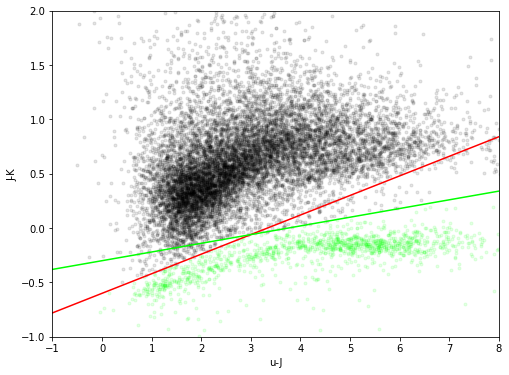

In [22]:
# 3 - Star flag 

# From van der Burg 2020
# galaxies have 
# J-Ks > 0.18 (u-J) - 0.60  \cup  
# J-Ks > 0.08 (u-J) - 0.30
# or
# J-Ks > 0.18 (g-J) - 0.47  \cup  
# J-Ks > 0.08 (g-J) - 0.24

fu,fg,fJ,fK = phot_gclass[['u','g','J','Ks']].values.T
x1, x2, y = -2.5*np.log10(fu/fJ), -2.5*np.log10(fg/fJ), -2.5*np.log10(fJ/fK)
starflag = np.ones(len(phot_gclass), dtype=int)
starflag[~np.isnan(x1) & (x1<3)  & (y>0.18*x1-0.60)] = 0
starflag[~np.isnan(x1) & (x1>=3) & (y>0.08*x1-0.30)] = 0
starflag[np.isnan(x1) & ~np.isnan(x2) & (x2<2.3)  & (y>0.18*x2-0.47)] = 0
starflag[np.isnan(x1) & ~np.isnan(x2) & (x2>=2.3) & (y>0.08*x2-0.24)] = 0

phot_gclass['Star'] = starflag

fig, ax = plt.subplots(1,1,figsize=(8,6))
# cb = ax.scatter(x1, y, c=starflag, cmap='coolwarm', marker='.', alpha=0.1)
ax.scatter(x1[starflag==0], y[starflag==0], c='k', marker='.', alpha=0.1)
ax.scatter(x1[starflag==1], y[starflag==1], c='lime', marker='.', alpha=0.1)
xx = np.linspace(-30,10,10)
yy = 0.18*xx - 0.60
ax.plot(xx,yy, color='r')
yy = 0.08*xx - 0.30
ax.plot(xx,yy, color='lime')
ax.set(ylim=[-1,2], xlim=[-1,8], ylabel='J-K', xlabel='u-J')
# plt.colorbar(cb, label='Star')
plt.show()

In [23]:
# 4 - add unique PHOT identifiers
# first digit: 1 = GOGREEN, 2=GCLASS, 3=COSMOS, 4=SXDF

cluster_ids = {'SpARCS0034':215000000, 
               'SpARCS0036':216000000, 
               'SpARCS0215':217000000, 
               'SpARCS1047':218000000, 
               'SpARCS1613':219000000, 
               }

phot_gclass['PHOTID'] = phot_gclass['PHOTID'].values.astype(int)
phot_gclass['cPHOTID'] = np.full(len(phot_gclass), -1, dtype=int)

for group,cid in cluster_ids.items():
    group_indices = phot_gclass.query('Cluster=="{}"'.format(group)).index.values
    
    phot_gclass.loc[group_indices,'cPHOTID'] = phot_gclass.loc[group_indices,'PHOTID'] + cid

In [24]:
# 5 - Match to spectroscopy - we want to include spectroscopic redshifts and redshift flags, match based on SPECID 

phot_gclass.rename(columns={'GCLASSSPECID':'SPECID'}, inplace=True)
phot_gclass = pd.merge(phot_gclass, redshift_table[['SPECID','Redshift','Redshift_Quality']], how='left', on='SPECID')

phot_gclass.loc[phot_gclass['SPECID'].isnull(),'SPECID'] = -1 # if object entry not in spectroscopic sample, change value of SPECID to -1
phot_gclass['SPECID'] = phot_gclass['SPECID'].astype(int) # make sure int type

In [25]:
# 6 - rename columns to standard form 

phot_gclass_std = phot_gclass.rename(columns={'Redshift':'zspec_gogreen' })

phot_gclass_std['zspec'] = phot_gclass_std['z_spec_eazy'].values
# idxs = phot_gclass_std.query('z_spec_eazy.isnull() & ~zspec_gogreen.isnull()').index.values # Doesn't seem to work with all pandas distributions
idxs = phot_gclass_std.index.values[phot_gclass_std['z_spec_eazy'].isnull() & ~phot_gclass_std['zspec_gogreen'].isnull()] 
phot_gclass_std.loc[idxs,'zspec'] = phot_gclass_std.loc[idxs,'zspec_gogreen'].values

phot_gclass_std['zphot'] = np.full(len(phot_gclass_std), np.nan)
phot_gclass_std['zphot_l68'] = np.full(len(phot_gclass_std), np.nan)
phot_gclass_std['zphot_u68'] = np.full(len(phot_gclass_std), np.nan)

# idxs = phot_gclass_std.query('z_spec_eazy!=z_peak_eazy').index.values # Doesn't seem to work with all pandas distributions
idxs = phot_gclass_std.index.values[ phot_gclass_std['z_spec_eazy'].values != phot_gclass_std['z_peak_eazy'].values ]
phot_gclass_std.loc[idxs,'zphot'] = phot_gclass_std.loc[idxs,'z_peak_eazy']
phot_gclass_std.loc[idxs,'zphot_l68'] = phot_gclass_std.loc[idxs,'z_peak_eazy_l68']
phot_gclass_std.loc[idxs,'zphot_u68'] = phot_gclass_std.loc[idxs,'z_peak_eazy_u68']

phot_gclass_std['Mstellar'] = np.power(10., phot_gclass_std['lmass'].values)
phot_gclass_std['K_fluxrad'] = np.full(len(phot_gclass_std), np.nan)
phot_gclass_std['totmask'] = np.full(len(phot_gclass_std), 0)

cols = ['Cluster','cPHOTID','ra','dec','SPECID','zspec','Redshift_Quality','K_flag','Star','K_fluxrad','totmask','zphot','zphot_l68','zphot_u68',\
        'UMINV','VMINJ','Mstellar'] 
photcols = ['u_tot','g_tot','r_tot','i_tot','z_tot','J_tot','Ks_tot','IRAC1_tot','IRAC2_tot','IRAC3_tot','IRAC4_tot']
cols += photcols + ['e'+pc for pc in photcols] + ['zspec_gogreen','z_rfcols']
phot_gclass_std = phot_gclass_std[cols]

In [26]:
phot_gclass_std.to_csv(catdir+'table3_gclass.csv', index=False)

## Compile all COSMOS photometric information

The photometric information is split across several catalogues, we want to:
1. combine all photometric catalogues
2. convert fluxes to total fluxes
3. Star flag indicator -- nothing here, just use UltraVISTA classification (just renamed column)
4. add unique PHOTID to specify cluster (where first digit 1 indicates GOGREEN)
5. match to spectroscopic catalogue to include spec-redshifts
6. rename columns to standard form


In [27]:
# specify file names

# contains information for: 'COSMOS-125', 'COSMOS-221', 'COSMOS-28', 'COSMOS-63', all use the same catalogues

idx = cluster_table.query('cluster == "COSMOS-125"').index[0]
fname_kphot, fname_photoz, fname_stellmass = cluster_table.loc[idx,['Kphot_cat','photoz_cat','stelmass_cat']].values.T

fname_kphot     = photdir + 'COSMOS/' + fname_kphot.rstrip()
fname_stellmass = photdir + 'COSMOS/' + fname_stellmass.rstrip()
fname_photoz    = photdir + 'COSMOS/' + fname_photoz.rstrip()

In [28]:
# 1 - combine UltraVISTA catalogue with FAST output (for stellar masses and peak redshift) and rest-frame colours tables

# read in UltraVISTA catalogue
phot_cosmos_1 = Table(fits.getdata(fname_kphot)).to_pandas()
phot_cosmos_1.rename(columns={'id':'PHOTID'}, inplace=True) # rename colums
phot_cosmos_1.replace([-1,-99,-99.9], np.nan, inplace=True)
# phot_cosmos_1.replace(-99, np.nan, inplace=True)

# read in catalogue with masses and rest-frame colours
phot_cosmos_2 = pd.read_csv(fname_stellmass, skiprows=[1], delim_whitespace=True, header=0) # skip second line which is just a line of '='
phot_cosmos_2.rename(columns={'ID':'PHOTID', 'z_peak':'z_peak_fast','UmV':'UMINV','VmJ':'VMINJ'}, inplace=True) # rename colums

# read in catalogue with EAZY output
phot_cosmos_3 = Table(fits.getdata(fname_photoz)).to_pandas()
phot_cosmos_3.rename(columns={'id':'PHOTID', 'z_spec':'z_spec_eazy', 'z_peak':'z_peak_eazy', 'u68':'z_peak_eazy_u68', 'l68':'z_peak_eazy_l68'}, inplace=True) # rename colums


phot_cosmos = pd.merge(phot_cosmos_1, phot_cosmos_2[['PHOTID','UMINV','VMINJ','z_peak_fast','LMASS']], on='PHOTID', how='left')
phot_cosmos = pd.merge(phot_cosmos, phot_cosmos_3[['PHOTID','z_spec_eazy','z_peak_eazy','z_peak_eazy_u68','z_peak_eazy_l68']], on='PHOTID', how='left')
phot_cosmos = phot_cosmos.query('(USE==1)') # drop all rows which don't have USE==1 (see UltraVISTA documentation for details)


In [29]:
print(phot_cosmos.columns)
phot_cosmos.head()

Index(['PHOTID', 'ra', 'dec', 'xpix', 'ypix', 'Ks_tot', 'eKs_tot', 'Ks', 'eKs',
       'H', 'eH', 'J', 'eJ', 'Y', 'eY', 'ch4', 'ech4', 'ch3', 'ech3', 'ch2',
       'ech2', 'ch1', 'ech1', 'zp', 'ezp', 'ip', 'eip', 'rp', 'erp', 'V', 'eV',
       'gp', 'egp', 'B', 'eB', 'u', 'eu', 'IA484', 'eIA484', 'IA527', 'eIA527',
       'IA624', 'eIA624', 'IA679', 'eIA679', 'IA738', 'eIA738', 'IA767',
       'eIA767', 'IB427', 'eIB427', 'IB464', 'eIB464', 'IB505', 'eIB505',
       'IB574', 'eIB574', 'IB709', 'eIB709', 'IB827', 'eIB827', 'fuv', 'efuv',
       'nuv', 'enuv', 'mips24', 'emips24', 'K_flag', 'K_star', 'K_Kron',
       'apcor', 'z_spec', 'z_spec_cc', 'z_spec_id', 'star', 'contamination',
       'nan_contam', 'orig_cat_id', 'orig_cat_field', 'USE', 'UMINV', 'VMINJ',
       'z_peak_fast', 'LMASS', 'z_spec_eazy', 'z_peak_eazy', 'z_peak_eazy_u68',
       'z_peak_eazy_l68'],
      dtype='object')


,PHOTID,ra,dec,xpix,ypix,Ks_tot,eKs_tot,Ks,eKs,H,eH,J,eJ,Y,eY,ch4,ech4,ch3,ech3,ch2,ech2,ch1,ech1,zp,ezp,ip,eip,rp,erp,V,eV,gp,egp,B,eB,u,eu,IA484,eIA484,IA527,eIA527,IA624,eIA624,IA679,eIA679,IA738,eIA738,IA767,eIA767,IB427,eIB427,IB464,eIB464,IB505,eIB505,IB574,eIB574,IB709,eIB709,IB827,eIB827,fuv,efuv,nuv,enuv,mips24,emips24,K_flag,K_star,K_Kron,apcor,z_spec,z_spec_cc,z_spec_id,star,contamination,nan_contam,orig_cat_id,orig_cat_field,USE,UMINV,VMINJ,z_peak_fast,LMASS,z_spec_eazy,z_peak_eazy,z_peak_eazy_u68,z_peak_eazy_l68
0,1,150.37265,1.609394,11986.75879,4343.98486,6345.683,8.535,2458.348,3.069,2554.732,2.205,2011.244,1.855,1665.491,2.055,2229.020,11.092,1159.925,63.576,1238.034,63.029,1513.357,76.582,-99.999,-99.999,-99.999,-99.999,609.524,1.071,430.542,0.779,293.832,0.365,201.463,0.499,88.605,1.054,316.139,2.791,426.547,2.960,659.435,3.337,761.369,2.897,982.764,3.981,915.068,3.799,147.845,2.344,284.971,2.969,413.933,3.471,520.958,3.385,761.208,3.425,1299.578,4.812,27.115,0.127,32.692,0.134,3946.924,11.148,0.0,0.03,27.50304,1.00000,NaN,NaN,NaN,0,0,2,230,1,1,1.75,1.40,0.1257,10.83,-1.0,0.1257,0.143,0.109
2,3,150.40550,1.606911,11198.41992,4284.49414,223.931,3.299,111.582,0.887,94.436,0.678,67.895,0.511,61.085,0.507,64.002,6.935,55.312,8.437,65.572,4.568,88.131,5.368,46.054,0.342,36.760,0.223,20.608,0.206,11.796,0.140,8.360,0.086,6.925,0.100,4.889,0.251,8.405,0.461,10.009,0.460,22.655,0.625,28.231,0.567,34.231,0.754,37.358,0.781,6.587,0.501,7.931,0.507,9.492,0.535,15.271,0.591,30.671,0.695,38.314,0.841,1.864,0.125,4.507,0.130,142.376,9.231,0.0,0.03,17.73935,1.00000,NaN,NaN,NaN,0,0,0,314,1,1,1.24,1.02,0.5469,10.50,-1.0,0.5469,0.577,0.517
3,4,150.39050,1.604330,11558.18359,4222.49707,33.437,1.502,23.667,0.681,16.188,0.566,11.345,0.410,8.666,0.358,6.252,7.394,16.608,6.876,12.765,1.795,25.299,2.120,6.197,0.216,4.550,0.115,1.558,0.082,0.789,0.064,0.392,0.062,0.305,0.044,0.183,0.065,0.463,0.131,0.906,0.157,1.353,0.177,2.328,0.190,3.503,0.273,4.320,0.300,0.098,0.099,0.257,0.142,0.455,0.152,0.721,0.172,3.101,0.241,5.155,0.342,0.047,0.304,-0.538,0.245,21.609,8.478,0.0,0.75,11.57455,1.00248,NaN,NaN,NaN,0,0,0,322,1,1,1.76,1.26,0.7169,9.94,-1.0,0.7169,0.771,0.670
4,5,150.40334,1.606078,11250.56543,4264.48291,214.863,2.457,119.658,0.903,106.466,0.694,78.345,0.527,59.298,0.503,49.340,7.938,32.512,7.275,45.757,3.507,65.031,4.141,45.696,0.341,35.212,0.219,18.632,0.197,12.215,0.142,6.193,0.080,3.985,0.080,1.681,0.152,5.933,0.390,9.985,0.459,18.737,0.570,24.921,0.534,31.800,0.728,37.757,0.785,3.026,0.344,4.689,0.396,8.808,0.516,15.762,0.600,28.346,0.668,36.858,0.825,0.605,0.163,0.424,0.176,24.870,9.224,0.0,0.03,14.82747,1.00000,NaN,NaN,NaN,0,0,0,340,1,1,1.98,1.48,0.2395,9.97,-1.0,0.2395,0.268,0.215
7,8,150.40303,1.604402,11257.65820,4224.25977,2.992,0.400,3.552,0.624,2.281,0.543,1.149,0.389,1.244,0.331,0.160,6.370,7.531,7.219,-1.712,1.519,3.977,1.286,1.574,0.196,1.389,0.098,1.216,0.078,1.255,0.069,1.090,0.065,1.061,0.053,0.932,0.117,1.253,0.191,1.108,0.169,1.361,0.177,1.284,0.157,1.517,0.206,1.142,0.200,0.924,0.201,1.053,0.211,1.179,0.210,1.171,0.199,1.455,0.181,1.493,0.228,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.35,5.56795,1.07270,NaN,NaN,NaN,0,0,0,346,1,1,0.42,0.32,2.3553,9.38,-1.0,2.3553,2.502,2.260


In [30]:
# 2 - flux calibrate

photcols = ['H', 'eH', 'J', 'eJ', 'Y', 'eY', 'ch4', 'ech4', 'ch3', 'ech3', 'ch2', 'ech2', 'ch1', 'ech1', \
           'zp', 'ezp', 'ip', 'eip', 'rp', 'erp', 'V', 'eV', 'gp', 'egp', 'B', 'eB', 'u', 'eu',
           'IA484', 'eIA484', 'IA527', 'eIA527', 'IA624', 'eIA624', 'IA679', 'eIA679', 'IA738', 'eIA738', 'IA767', \
           'eIA767', 'IB427', 'eIB427', 'IB464', 'eIB464', 'IB505', 'eIB505', 'IB574', 'eIB574', 'IB709', 'eIB709', 'IB827', 'eIB827', \
           'fuv', 'efuv', 'nuv', 'enuv', 'mips24', 'emips24','Ks','eKs']

ks_tot, ks_ap = phot_cosmos[['Ks_tot','Ks']].values.T

for col in photcols:
    newcol = col+'_tot'
    if newcol not in phot_cosmos.columns:
        phot_cosmos[newcol] = phot_cosmos[col].values * ks_tot / ks_ap


In [31]:
# 3 - Star flag (just use UltraVISTA star selection)

# From UltraVISTA README
# 14. star - Classification of the object as a star/galaxy.  Value = 1 is a star, Value = 0 is a galaxy.  Classification is done  based on location of stars in the U-J vs. J-K color-color plot.

phot_cosmos.rename(columns={'star':'Star'}, inplace=True) 


In [32]:
# 4 - unique PHOTID identifiers
phot_cosmos['cPHOTID'] = 13000000 + phot_cosmos['PHOTID']


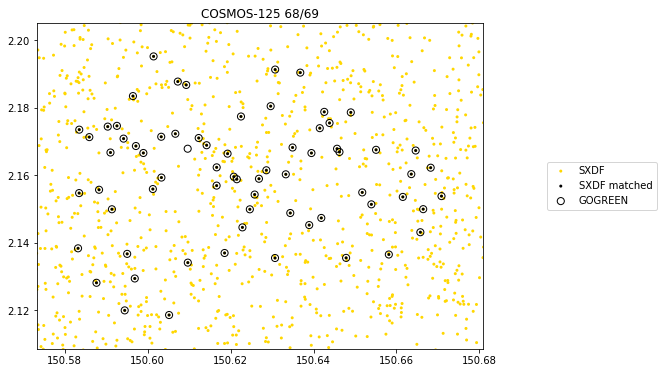

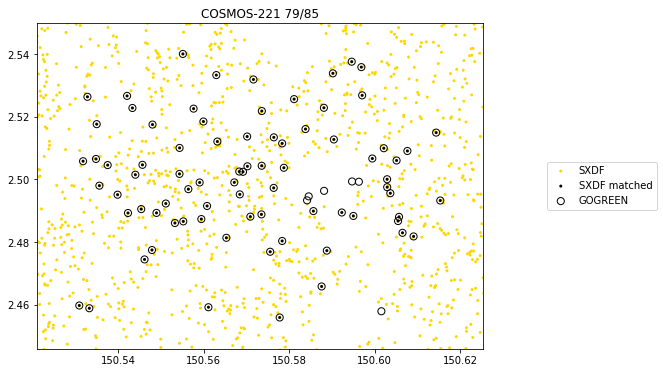

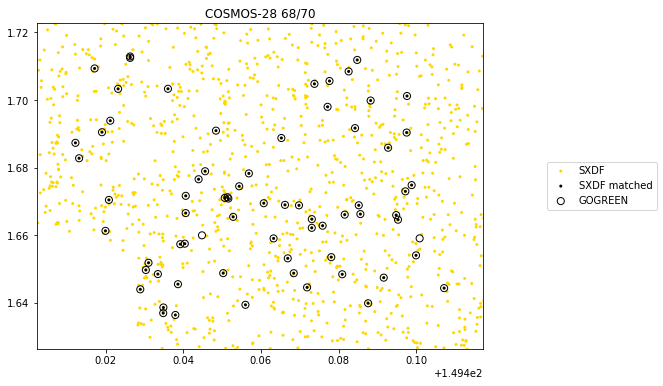

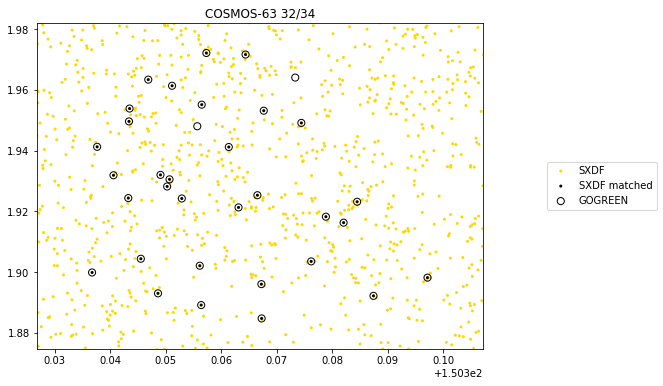

In [33]:
# 5 - Match to spectroscopy

maxdist = 1.5/3600. # radius of circle to select nearby objects for potential match

phot_cosmos['Cluster'] = np.full(len(phot_cosmos), 'COSMOS')
phot_cosmos['SPECID'] = np.full(len(phot_cosmos), -1)
phot_cosmos['Redshift'] = np.full(len(phot_cosmos), np.nan)
phot_cosmos['Redshift_Quality'] = np.full(len(phot_cosmos), np.nan)

# make a catalogue of all coordinates in COSMOS table
ras, decs = phot_cosmos[['ra','dec']].values.T
catalog = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)

# iterate through spectroscopy catalogue, finding matches based on RA and DEC
for group in np.unique(redshift_table['Cluster']):
    if 'COSMOS' not in group: continue
    gtable = redshift_table.query('Cluster=="{}"'.format(group))
    idx_matches, missing = [], 0
    
    for idx in gtable.index:
        
        ra, dec, z = gtable.loc[idx,['RA(J2000)','DEC(J2000)','Redshift']].values.T
        coo = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)

        coo_matches, sep2d, _ = match_coordinates_sky(coo, catalog, 1, storekdtree=True) # finds NEAREST neighbour
        idx_match = phot_cosmos.index[coo_matches.tolist()]

        if np.min(sep2d.degree) < maxdist:
#             redshift_table.loc[idx,'sxdf_id'] = phot_cosmos.loc[idx_match,'ID']
            phot_cosmos.loc[idx_match,'SPECID']           = redshift_table.loc[idx,'SPECID']
            phot_cosmos.loc[idx_match,'Redshift']         = redshift_table.loc[idx,'Redshift']
            phot_cosmos.loc[idx_match,'Redshift_Quality'] = redshift_table.loc[idx,'Redshift_Quality']
            phot_cosmos.loc[idx_match,'Cluster']          = group
            idx_matches.append(idx_match)
            
        else:
            missing +=1
                    
    fig, ax = plt.subplots(1,1,figsize=(8,6))

    ax.scatter(ras, decs, c='gold', marker='.', edgecolor='None', label="SXDF")
    ax.scatter(phot_cosmos.loc[idx_matches,'ra'], phot_cosmos.loc[idx_matches,'dec'], c='k', marker='.', edgecolor='None', label="SXDF matched")
    ax.scatter(gtable['RA(J2000)'].values,  gtable['DEC(J2000)'].values, c='None', marker='o', edgecolor='k', s=50, label="GOGREEN")

    ax.set(title=group+' {}/{}'.format(len(idx_matches), len(idx_matches)+missing))
    ax.legend(bbox_to_anchor=[1.4, 0.5], loc='center right')
    xmin, xmax = np.min(gtable['RA(J2000)'].values), np.max(gtable['RA(J2000)'].values)
    ymin, ymax = np.min(gtable['DEC(J2000)'].values), np.max(gtable['DEC(J2000)'].values)
    ax.set_xlim(xmin-0.01,xmax+0.01)
    ax.set_ylim(ymin-0.01, ymax+0.01)
    plt.show()
    

In [34]:
# 6 - rename columns to standard form
rename_phot_cosmos = {  'ch4_tot':'IRAC4_tot',
                        'ech4_tot':'eIRAC4_tot',
                        'ch3_tot':'IRAC3_tot',
                        'ech3_tot':'eIRAC3_tot',
                        'ch2_tot':'IRAC2_tot',
                        'ech2_tot':'eIRAC2_tot',
                        'ch1_tot':'IRAC1_tot',
                        'ech1_tot':'eIRAC1_tot',
                        'zp_tot':'z_tot',
                        'ezp_tot':'ez_tot',
                        'ip_tot':'i_tot',
                        'eip_tot':'ei_tot',
                        'rp_tot':'r_tot',
                        'erp_tot':'er_tot',
                        'V_tot':'V_tot',
                        'eV_tot':'eV_tot',
                        'gp_tot':'g_tot',
                        'egp_tot':'eg_tot',
                        'B_tot':'B_tot',
                        'eB_tot':'eB_tot',
                        'u_tot':'u_tot',
                        'eu_tot':'eu_tot',
                        'Y_tot':'y_tot',
                        'eY_tot':'ey_tot',
                     }

phot_cosmos_std = phot_cosmos.rename(columns=rename_phot_cosmos)

phot_cosmos_std['zspec_gogreen']   = phot_cosmos_std['Redshift'].values

phot_cosmos_std['zspec'] = phot_cosmos_std['z_spec'].values
# idxs = phot_cosmos_std.query('z_spec.isnull() & ~zspec_gogreen.isnull()').index.values # Doesn't seem to work with all pandas distributions
idxs = phot_cosmos_std.index.values[phot_cosmos_std['z_spec_eazy'].isnull() & ~phot_cosmos_std['zspec_gogreen'].isnull()] 
phot_cosmos_std.loc[idxs,'zspec'] = phot_cosmos_std.loc[idxs,'Redshift'].values

phot_cosmos_std['zphot'] = np.full(len(phot_cosmos_std), np.nan)
phot_cosmos_std['zphot_l68'] = np.full(len(phot_cosmos_std), np.nan)
phot_cosmos_std['zphot_u68'] = np.full(len(phot_cosmos_std), np.nan)

# idxs = phot_cosmos_std.query('z_spec!=z_peak_eazy').index.values # Doesn't seem to work with all pandas distributions
idxs = phot_cosmos_std.index.values[ phot_cosmos_std['z_spec'].values != phot_cosmos_std['z_peak_eazy'].values ]
phot_cosmos_std.loc[idxs,'zphot'] = phot_cosmos_std.loc[idxs,'z_peak_eazy']
phot_cosmos_std.loc[idxs,'zphot_l68'] = phot_cosmos_std.loc[idxs,'z_peak_eazy_l68']
phot_cosmos_std.loc[idxs,'zphot_u68'] = phot_cosmos_std.loc[idxs,'z_peak_eazy_u68']

phot_cosmos_std['Mstellar']   = np.power(10., phot_cosmos_std['LMASS'].values)
phot_cosmos_std['K_fluxrad']  = np.full(len(phot_cosmos_std), np.nan)
phot_cosmos_std['totmask']    = np.full(len(phot_cosmos_std), 0)

photcols2 = ['IRAC1_tot', 'eIRAC1_tot', 'IRAC2_tot', 'eIRAC2_tot', 'IRAC3_tot', 'eIRAC3_tot', 'IRAC4_tot', 'eIRAC4_tot', \
             'H_tot', 'eH_tot', 'J_tot', 'eJ_tot', 'y_tot', 'ey_tot', 'z_tot', 'ez_tot', 'i_tot', 'ei_tot', 'r_tot', 'er_tot', \
             'V_tot', 'eV_tot', 'g_tot', 'eg_tot', 'B_tot', 'eB_tot', 'u_tot', 'eu_tot',
             'IA484_tot', 'eIA484_tot', 'IA527_tot', 'eIA527_tot', 'IA624_tot', 'eIA624_tot', 'IA679_tot', 'eIA679_tot', \
             'IA738_tot', 'eIA738_tot', 'IA767_tot', 'eIA767_tot', 'IB427_tot', 'eIB427_tot', 'IB464_tot', 'eIB464_tot', \
             'IB505_tot', 'eIB505_tot', 'IB574_tot', 'eIB574_tot', 'IB709_tot', 'eIB709_tot', 'IB827_tot', 'eIB827_tot', \
             'fuv_tot', 'efuv_tot', 'nuv_tot', 'enuv_tot', 'mips24_tot', 'emips24_tot','Ks_tot','eKs_tot']
cols = ['Cluster','cPHOTID','ra','dec','SPECID','zspec','Redshift_Quality','K_flag','Star','K_fluxrad','totmask','zphot','zphot_l68','zphot_u68',\
        'UMINV','VMINJ','Mstellar','zspec_gogreen'] + photcols2 
phot_cosmos_std = phot_cosmos_std[cols]



In [35]:
phot_cosmos_std.to_csv(catdir+'table3_cosmos.csv', index=False)

## Compile all SXDF photometric information

The file SPLASH_SXDF_Mehta+_v1.6_GOGREEN_FOV_rfcolours.csv is a subset of the full SXDF catalogue SPLASH_SXDF_Mehta+_v1.6.fits which includes GOGREEN equivalent fluxes and rest-frame colours

Working form the SPLASH_SXDF_Mehta+_v1.6_GOGREEN_FOV_rfcolours.csv catalogue we want to:
1. read in the photometric catalogues
2. drop irrelevant columns (for convenice, just because there are _so many_ columns)
3. add unique PHOTID to specify cluster (where first digit 1 indicates GOGREEN)
4. add STAR indicator (where really we've pre-selected all objects to be galaxies based on SXDF classification)
5. set default cluster name to entries not in the GOGREEN spectroscopic sample
6. rename photometric band columns to be not instrument specific
7. rename columns to standard form


In [36]:
# 1 - read in catalogue

phot_sxdf = pd.read_csv(photdir + 'SXDF/SPLASH_SXDF_Mehta+_v1.6_GOGREEN_FOV_rfcolours.csv', low_memory=False)

phot_sxdf.rename(columns={'ID':'PHOTID'}, inplace=True)


In [37]:
# 2 - drop flux columsn which are not total fluxes
dropcols = []
for col in phot_sxdf.columns:
    if ('FLUX' in col) and (('_TOT_' not in col) | ('_SI' not in col)):
        dropcols.append(col)
phot_sxdf.drop(columns=dropcols, inplace=True)

In [38]:
print(phot_sxdf.columns)
phot_sxdf.head()

Index(['PHOTID', 'RA', 'DEC', 'MASS_BEST', 'STAR_FLAG', 'ZSPEC', 'ZPHOT',
       'Z_MED', 'Z_MED_U68', 'Z_MED_L68', 'Z_BEST', 'Z_BEST_L68', 'Z_BEST_U68',
       'FLUX_TOT_irac_1_SI', 'FLUX_TOT_irac_2_SI', 'FLUX_TOT_irac_3_SI',
       'FLUX_TOT_irac_4_SI', 'FLUXERR_TOT_irac_1_SI', 'FLUXERR_TOT_irac_2_SI',
       'FLUXERR_TOT_irac_3_SI', 'FLUXERR_TOT_irac_4_SI', 'FLUX_TOT_hsc_g_SI',
       'FLUXERR_TOT_hsc_g_SI', 'FLUX_TOT_hsc_r_SI', 'FLUXERR_TOT_hsc_r_SI',
       'FLUX_TOT_hsc_i_SI', 'FLUXERR_TOT_hsc_i_SI', 'FLUX_TOT_hsc_z_SI',
       'FLUXERR_TOT_hsc_z_SI', 'FLUX_TOT_hsc_y_SI', 'FLUXERR_TOT_hsc_y_SI',
       'FLUX_TOT_supcam_b_SI', 'FLUXERR_TOT_supcam_b_SI',
       'FLUX_TOT_supcam_v_SI', 'FLUXERR_TOT_supcam_v_SI',
       'FLUX_TOT_supcam_r_SI', 'FLUXERR_TOT_supcam_r_SI',
       'FLUX_TOT_supcam_i_SI', 'FLUXERR_TOT_supcam_i_SI',
       'FLUX_TOT_supcam_z_SI', 'FLUXERR_TOT_supcam_z_SI', 'FLUX_TOT_uds_j_SI',
       'FLUXERR_TOT_uds_j_SI', 'FLUX_TOT_uds_h_SI', 'FLUXERR_TOT_uds_h_SI',
    

,PHOTID,RA,DEC,MASS_BEST,STAR_FLAG,ZSPEC,ZPHOT,Z_MED,Z_MED_U68,Z_MED_L68,Z_BEST,Z_BEST_L68,Z_BEST_U68,FLUX_TOT_irac_1_SI,FLUX_TOT_irac_2_SI,FLUX_TOT_irac_3_SI,FLUX_TOT_irac_4_SI,FLUXERR_TOT_irac_1_SI,FLUXERR_TOT_irac_2_SI,FLUXERR_TOT_irac_3_SI,FLUXERR_TOT_irac_4_SI,FLUX_TOT_hsc_g_SI,FLUXERR_TOT_hsc_g_SI,FLUX_TOT_hsc_r_SI,FLUXERR_TOT_hsc_r_SI,FLUX_TOT_hsc_i_SI,FLUXERR_TOT_hsc_i_SI,FLUX_TOT_hsc_z_SI,FLUXERR_TOT_hsc_z_SI,FLUX_TOT_hsc_y_SI,FLUXERR_TOT_hsc_y_SI,FLUX_TOT_supcam_b_SI,FLUXERR_TOT_supcam_b_SI,FLUX_TOT_supcam_v_SI,FLUXERR_TOT_supcam_v_SI,FLUX_TOT_supcam_r_SI,FLUXERR_TOT_supcam_r_SI,FLUX_TOT_supcam_i_SI,FLUXERR_TOT_supcam_i_SI,FLUX_TOT_supcam_z_SI,FLUXERR_TOT_supcam_z_SI,FLUX_TOT_uds_j_SI,FLUXERR_TOT_uds_j_SI,FLUX_TOT_uds_h_SI,FLUXERR_TOT_uds_h_SI,FLUX_TOT_uds_k_SI,FLUXERR_TOT_uds_k_SI,FLUX_TOT_video_z_SI,FLUXERR_TOT_video_z_SI,FLUX_TOT_video_y_SI,FLUXERR_TOT_video_y_SI,FLUX_TOT_video_j_SI,FLUXERR_TOT_video_j_SI,FLUX_TOT_video_h_SI,FLUXERR_TOT_video_h_SI,FLUX_TOT_video_ks_SI,FLUXERR_TOT_video_ks_SI,FLUX_TOT_musubi_u_SI,FLUXERR_TOT_musubi_u_SI,FLUX_TOT_cfhtls_u_SI,FLUXERR_TOT_cfhtls_u_SI,FLUX_TOT_cfhtls_g_SI,FLUXERR_TOT_cfhtls_g_SI,FLUX_TOT_cfhtls_r_SI,FLUXERR_TOT_cfhtls_r_SI,FLUX_TOT_cfhtls_i_SI,FLUXERR_TOT_cfhtls_i_SI,FLUX_TOT_cfhtls_z_SI,FLUXERR_TOT_cfhtls_z_SI,SPECID,Redshift,Redshift_Quality,Cluster,UMINV,VMINJ,REDSHIFTUSED,U_rf,V_rf,J_rf
0,117803,34.573310,-5.521233,10.71000,0,NaN,1.0416,NaN,NaN,NaN,1.0416,1.0399,1.0402,1848.400015,1243.612916,802.685092,356.193353,19.304415,17.102646,8.108952,35.303912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,357.887360,0.024023,358.322880,0.035955,388.357760,0.038203,469.257300,0.047524,1270.701400,0.113829,7399.429700,0.159411,6504.415500,0.266265,4048.101600,0.194069,8638.312500,0.187575,8581.753000,0.277831,7665.419400,0.487979,6337.993000,0.670977,4463.744600,0.912515,2573.281500,0.024570,2038.854600,0.141792,NaN,NaN,4355.763000,0.171338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.048126,1.000036,1.0416,1444.6500,8298.7600,17261.9000
1,120466,34.699258,-5.521618,9.57268,0,NaN,1.4596,1.4596,1.4687,1.4501,1.4604,1.4553,1.4656,25.204131,29.115701,25.283272,237.096751,0.640161,0.914926,4.464842,25.287203,-3.455643,-0.040620,-3.514208,-0.057104,-4.037088,-0.062074,-4.526074,-0.109986,-4.997293,-0.219496,-3.335961,-0.015672,-3.558954,-0.023992,-3.620242,-0.025607,-3.990018,-0.031722,-4.297718,-0.075504,-7.633792,-0.095321,-8.601892,-0.157213,-9.427548,-0.118408,-5.783723,-0.110720,-7.487950,-0.167453,-9.502441,-0.290828,-8.563959,-0.407325,-9.222444,-0.547678,-2.972664,-0.015295,-2.303449,-0.064250,-3.019356,-0.053048,-3.043570,-0.092797,-4.237842,-0.159045,-3.481545,-0.643589,NaN,NaN,NaN,NaN,NaN,NaN,1.4596,NaN,NaN,NaN
2,120603,34.578078,-5.521859,10.71310,0,NaN,1.0551,1.0551,1.0663,1.0331,1.0594,1.0563,1.0629,297.491913,393.606755,440.041459,621.214031,3.828212,3.359705,3.648063,17.774683,3.588157,0.058296,8.787316,0.092709,20.221027,0.112634,37.220203,0.201310,50.947250,0.398346,3.007667,0.026603,4.727402,0.039795,9.123575,0.042168,15.502804,0.052513,30.072485,0.126360,64.777950,0.175886,109.217865,0.292650,141.400560,0.213691,32.987312,0.206507,56.814323,0.314478,70.068405,0.535506,112.712510,0.729450,152.413350,0.996455,1.940123,0.027051,1.623535,0.119029,2.926872,0.085779,6.658257,0.188293,15.909410,0.254904,22.640053,1.138707,NaN,NaN,NaN,NaN,1.602945,1.293810,1.0551,39.6244,151.0570,476.4960
3,120727,34.767935,-5.508610,11.76850,0,NaN,1.0770,NaN,NaN,NaN,1.0770,1.0795,1.0801,11603.678476,8091.370024,5374.707113,2911.897915,228.843231,153.112423,64.166543,97.497442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439.873350,0.025314,456.796000,0.044645,487.616940,0.046740,517.369930,0.057960,1621.845500,0.138540,43744.766000,0.161347,42677.150000,0.267381,28612.756000,0.200388,30486.562000,0.161151,40570.086000,0.256322,29264.188000,0.424493,30838.880000,0.592605,28434.684000,0.807332,4287.105500,0.029788,3269.658200,0.129529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.928578,1.575668,1.0770,

In [39]:
# 3 - add unique PHOTID identifiers
phot_sxdf['cPHOTID'] = 414000000 + phot_sxdf['PHOTID']

In [40]:
# 4 - add star indicators

# note that in parsing the full SXDF catalgues I selected only entried with STAR_FLAG=0, so set all flags to 0 in out table
phot_sxdf['Star'] = np.zeros(len(phot_sxdf), dtype=int) # dropped all entries with 'STAR_FLAG'!=0, where STAR_FLAG==0 are galaxies 

In [41]:
# 5 - Set default cluster name to SXDF and SPECID -1 (where not matched with spectroscopic catalogue)
phot_sxdf.loc[phot_sxdf.query('Cluster.isnull()').index.values,'Cluster'] = 'SXDF'
phot_sxdf.loc[phot_sxdf.query('SPECID.isnull()').index.values,'SPECID'] = -1

In [42]:
# 6 - rename photcols to be instrument non-specific

# u - musubi*, cftls
# g - hsc*, cftls
# r - hsc*, cftls, supcam
# i - hsc*, supcam, cftls
# z - hsc*, supcam, video, cftls
# y - hsc*, video
# B - supcam*
# V - supcam*
# J - uds*, video
# K - uds*
# Ks - video*
# H - uds*, video
# * indicates used this band (rarely problematic)

rename_photcols = { 'FLUX_TOT_irac_1_SI':'IRAC1_tot',
                    'FLUX_TOT_irac_2_SI':'IRAC2_tot',
                    'FLUX_TOT_irac_3_SI':'IRAC3_tot',
                    'FLUX_TOT_irac_4_SI':'IRAC4_tot',
                    'FLUXERR_TOT_irac_1_SI':'eIRAC1_tot',
                    'FLUXERR_TOT_irac_2_SI':'eIRAC2_tot',
                    'FLUXERR_TOT_irac_3_SI':'eIRAC3_tot',
                    'FLUXERR_TOT_irac_4_SI':'eIRAC4_tot',
                    'FLUX_TOT_hsc_g_SI':'g_tot',
                    'FLUXERR_TOT_hsc_g_SI':'eg_tot',
                    'FLUX_TOT_hsc_r_SI':'r_tot',
                    'FLUXERR_TOT_hsc_r_SI':'er_tot',
                    'FLUX_TOT_hsc_i_SI':'i_tot',
                    'FLUXERR_TOT_hsc_i_SI':'ei_tot',
                    'FLUX_TOT_hsc_z_SI':'z_tot',
                    'FLUXERR_TOT_hsc_z_SI':'ez_tot',
                    'FLUX_TOT_hsc_y_SI':'y_tot',
                    'FLUXERR_TOT_hsc_y_SI':'ey_tot',
                    'FLUX_TOT_supcam_b_SI':'B_tot',
                    'FLUXERR_TOT_supcam_b_SI':'eB_tot',
                    'FLUX_TOT_supcam_v_SI':'V_tot',
                    'FLUXERR_TOT_supcam_v_SI':'eV_tot',
#                     'FLUX_TOT_supcam_r_SI':'r',
#                     'FLUXERR_TOT_supcam_r_SI':'er',
#                     'FLUX_TOT_supcam_i_SI':'i',
#                     'FLUXERR_TOT_supcam_i_SI':'ei',
#                     'FLUX_TOT_supcam_z_SI':'z',
#                     'FLUXERR_TOT_supcam_z_SI':'ez',
                    'FLUX_TOT_uds_j_SI':'J_tot',
                    'FLUXERR_TOT_uds_j_SI':'eJ_tot',
                    'FLUX_TOT_uds_h_SI':'H_tot',
                    'FLUXERR_TOT_uds_h_SI':'eH_tot',
                    'FLUX_TOT_uds_k_SI':'K_tot',
                    'FLUXERR_TOT_uds_k_SI':'eK_tot',
#                     'FLUX_TOT_video_z_SI':'z_tot',
#                     'FLUXERR_TOT_video_z_SI':'ez_tot',
#                     'FLUX_TOT_video_y_SI':'y_tot',
#                     'FLUXERR_TOT_video_y_SI':'ey_tot',
#                     'FLUX_TOT_video_j_SI':'j',
#                     'FLUXERR_TOT_video_j_SI':'ej',
#                     'FLUX_TOT_video_h_SI':'h',
#                     'FLUXERR_TOT_video_h_SI':'eh',
                    'FLUX_TOT_video_ks_SI':'Ks_tot',
                    'FLUXERR_TOT_video_ks_SI':'eKs_tot',
                    'FLUX_TOT_musubi_u_SI':'u_tot',
                    'FLUXERR_TOT_musubi_u_SI':'eu_tot',
#                     'FLUX_TOT_cfhtls_u_SI':'u',
#                     'FLUXERR_TOT_cfhtls_u_SI':'eu',
#                     'FLUX_TOT_cfhtls_g_SI':'g',
#                     'FLUXERR_TOT_cfhtls_g_SI':'eg',
#                     'FLUX_TOT_cfhtls_r_SI':'r',
#                     'FLUXERR_TOT_cfhtls_r_SI':'er',
#                     'FLUX_TOT_cfhtls_i_SI':'i',
#                     'FLUXERR_TOT_cfhtls_i_SI':'ei',
#                     'FLUX_TOT_cfhtls_z_SI':'z',
#                     'FLUXERR_TOT_cfhtls_z_SI':'ez'
                    }

photcols = ["IRAC1_tot","eIRAC1_tot","IRAC2_tot","eIRAC2_tot","IRAC3_tot",'eIRAC3_tot','IRAC4_tot','eIRAC4_tot','g_tot','eg_tot',\
            'r_tot','er_tot','i_tot','ei_tot','z_tot','ez_tot','y_tot','ey_tot',\
             'B_tot','eB_tot','V_tot','eV_tot','J_tot','eJ_tot','K_tot','eK_tot','Ks_tot','eKs_tot','H_tot','eH_tot','u_tot','eu_tot']

In [43]:
# 7 - reanme columns to standard form

phot_sxdf_std = phot_sxdf.rename(columns={'RA':'ra','DEC':'dec'})
phot_sxdf_std.rename(columns=rename_photcols, inplace=True)
phot_sxdf_std['Mstellar']   = np.power(10., phot_sxdf_std['MASS_BEST'].values)
phot_sxdf_std['K_fluxrad']  = np.full(len(phot_sxdf_std), np.nan)
phot_sxdf_std['K_flag']     = np.full(len(phot_sxdf_std), np.nan)
phot_sxdf_std['totmask']    = np.full(len(phot_sxdf_std), 0)

phot_sxdf_std['zspec'] = phot_sxdf_std['ZSPEC'].values
# idxs = phot_sxdf_std.query('~Redshift.isnull()').index.values # Doesn't seem to work with all pandas distributions
idxs = phot_sxdf_std.index.values[ ~phot_sxdf_std['Redshift'].isnull() ]
phot_sxdf_std.loc[idxs,'zspec'] = phot_sxdf_std.loc[idxs,'Redshift'].values

phot_sxdf_std['zspec_gogreen'] = phot_sxdf_std['Redshift'].values

phot_sxdf_std['z_rfcols'] = phot_sxdf_std['REDSHIFTUSED'].values

phot_sxdf_std['zphot'] = phot_sxdf_std['ZPHOT'].values
# idxs = phot_sxdf_std.query('ZPHOT==Z_MED').index.values # Doesn't seem to work with all pandas distributions
idxs = phot_sxdf_std.index.values[ phot_sxdf_std['ZPHOT'].values == phot_sxdf_std['Z_MED'].values ]
phot_sxdf_std.loc[idxs,'zphot_u68'] = phot_sxdf_std.loc[idxs,'Z_MED_U68']
phot_sxdf_std.loc[idxs,'zphot_l68'] = phot_sxdf_std.loc[idxs,'Z_MED_L68']
# idxs = phot_sxdf_std.query('ZPHOT==Z_BEST').index.values # Doesn't seem to work with all pandas distributions
idxs = phot_sxdf_std.index.values[ phot_sxdf_std['ZPHOT'].values == phot_sxdf_std['Z_BEST'].values ]
phot_sxdf_std.loc[idxs,'zphot_u68'] = phot_sxdf_std.loc[idxs,'Z_BEST_U68']
phot_sxdf_std.loc[idxs,'zphot_l68'] = phot_sxdf_std.loc[idxs,'Z_BEST_L68']

cols = ['Cluster','cPHOTID','ra','dec','SPECID','zspec','Redshift_Quality','K_flag','Star','K_fluxrad','totmask','zphot','zphot_l68','zphot_u68',\
        'UMINV','VMINJ', 'Mstellar'] + photcols + ['zspec_gogreen','z_rfcols']
phot_sxdf_std = phot_sxdf_std[cols]



In [44]:
phot_sxdf_std.to_csv(catdir+'table3_sxdf.csv', index=False)

## Combine GOGREEN, GCLASS, COSMOS, and SXDF catalogues




In [45]:
phot_gogreen_std = pd.read_csv(catdir + 'table3_gogreen.csv')
phot_gclass_std  = pd.read_csv(catdir + 'table3_gclass.csv')
phot_cosmos_std  = pd.read_csv(catdir + 'table3_cosmos.csv')
phot_sxdf_std    = pd.read_csv(catdir + 'table3_sxdf.csv')

In [46]:
phot_merged = pd.concat([phot_gogreen_std, phot_cosmos_std], sort=False, ignore_index=True)
phot_merged = pd.concat([phot_merged, phot_sxdf_std], sort=False, ignore_index=True)
phot_merged = pd.concat([phot_merged, phot_gclass_std], sort=False, ignore_index=True)
phot_merged['cPHOTID'] = phot_merged['cPHOTID'].values.astype(int)
phot_merged['SPECID'] = phot_merged['SPECID'].values.astype(int)

In [49]:
# Write to fits tables

#           1            2          3       4   5      6        7                   8         9           10          11      12      13       14          15       16
allcols = ['Cluster', 'cPHOTID', 'SPECID','ra','dec', 'zspec', 'Redshift_Quality','zphot','zphot_l68','zphot_u68',  'UMINV', 'VMINJ', 'Star', 'K_flag','totmask', 'Mstellar'] # 'zspec_gogreen', 'K_fluxrad', 
# 17-46
allcols += ['u_tot', 'g_tot', 'r_tot', 'i_tot', 'z_tot', 'y_tot', 'V_tot',
       'B_tot', 'J_tot', 'H_tot', 'K_tot', 'Ks_tot', 'IRAC1_tot', 'IRAC2_tot',
       'IRAC3_tot', 'IRAC4_tot', 'IA484_tot', 'IA527_tot', 'IA624_tot',
       'IA679_tot', 'IA738_tot', 'IA767_tot', 'IB427_tot', 'IB464_tot',
       'IB505_tot', 'IB574_tot', 'IB709_tot', 'IB827_tot', 'fuv_tot',
       'nuv_tot', 'mips24_tot']
# 47-76
allcols+= ['eu_tot', 'eg_tot', 'er_tot', 'ei_tot', 'ez_tot', 'ey_tot',
       'eV_tot', 'eB_tot', 'eJ_tot', 'eH_tot', 'eK_tot', 'eKs_tot', 'eIRAC1_tot',
       'eIRAC2_tot', 'eIRAC3_tot', 'eIRAC4_tot', 'eIA484_tot',
       'eIA527_tot', 'eIA624_tot', 'eIA679_tot', 'eIA738_tot',
       'eIA767_tot', 'eIB427_tot', 'eIB464_tot', 'eIB505_tot',
       'eIB574_tot', 'eIB709_tot', 'eIB827_tot', 'efuv_tot', 'enuv_tot',
       'emips24_tot']
  
c1  = fits.Column(name='Cluster', array=phot_merged['Cluster'].values, format='10A')
c2  = fits.Column(name='cPHOTID', array=phot_merged['cPHOTID'].values, format='I32')
c3  = fits.Column(name='SPECID',  array=phot_merged['SPECID'].values,  format='I32')

cols = [c1,c2,c3]
for col in allcols[3:]:
    cols.append(fits.Column(name=col, array=phot_merged[col].values, format='F'))
    

table = fits.BinTableHDU.from_columns(cols)
table.writeto(catdir+'Photo.fits', overwrite=True)
